# Fashion MNIST Classification

This notebook trains a neural network model to classify images of clothing, like sneakers and shirts from the Fashion MNIST dataset, the sucessor of the famous MNIST dataset.

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


The Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories and  it is a slightly more challenging problem than regular MNIST . The images show individual articles of clothing at low resolution (28 by 28 pixels).

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents.

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Exploring the data

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

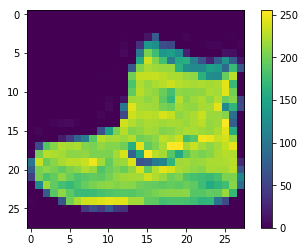

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

### Preprocessing

We scale the pixel values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. The training set and the testing set are preprocessed in the same way as it is necessary.

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Displaying the first 25 images from the dataset

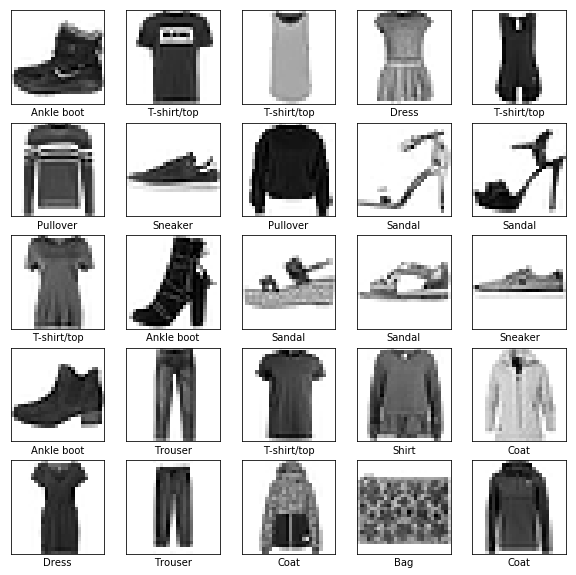

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Building the model

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels and only reformats the data.

After the pixels are flattened, the network consists of a sequence of two dense layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer is a 10-node softmax layer—this returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

The chosen loss function is the sparse categorical crossentropy which is suited for classification problems concerning the probability of an example being from a class. The use of the sparse one and not the simple one comes from the fact that the classes are enconded as integers and not with one hot. Lastly, the accuracy is a simple and direct metric for evaluating classification problems.

In [12]:
def build_model(nHidUnits=[128], nHidLayers=1):
    inp = keras.layers.Input(shape=(28, 28))
    flat = keras.layers.Flatten()(inp)
    li = keras.layers.Dense(nHidUnits[0], kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu)(flat)
    for i in range(nHidLayers-1):
        li = keras.layers.Dense(nHidUnits[i+1], kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu)(li)
    out = keras.layers.Dense(10, activation=tf.nn.softmax)(li)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

### Training the model

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_model([256])
hist = model.fit(train_images, train_labels, 
                 validation_split=0.2, batch_size=512,
                 epochs=100, callbacks=[early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 41us/sample - loss: 1.0171 - acc: 0.7648 - val_loss: 0.7564 - val_acc: 0.8299
Epoch 2/100
48000/48000 [==============================] - 2s 32us/sample - loss: 0.7007 - acc: 0.8401 - val_loss: 0.6641 - val_acc: 0.8440
Epoch 3/100
48000/48000 [==============================] - 2s 33us/sample - loss: 0.6134 - acc: 0.8532 - val_loss: 0.5945 - val_acc: 0.8543
Epoch 4/100
48000/48000 [==============================] - 2s 37us/sample - loss: 0.5616 - acc: 0.8594 - val_loss: 0.5680 - val_acc: 0.8533
Epoch 5/100
48000/48000 [==============================] - 2s 37us/sample - loss: 0.5313 - acc: 0.8632 - val_loss: 0.5291 - val_acc: 0.8616
Epoch 6/100
48000/48000 [==============================] - 2s 37us/sample - loss: 0.4960 - acc: 0.8699 - val_loss: 0.4962 - val_acc: 0.8655
Epoch 7/100
48000/48000 [=============

### Evaluation and analysis

It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of overfitting as the model performs worse on new data than on their training data. With that considered, the use of regularizers make it less of a problem and the accuracy on the validation and test data differ by less than 1% which is a good sign since the validation data is used to tweak the model and the test is completely new data.

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

print('Test accuracy: {:.2f} %'.format(test_acc*100))

Test accuracy: 87.97 %


By looking at evolution of the loss and accuracy on both the validation set, we can see that after around 20 epochs there is no significant improvement, so that justifies the use of the early stop during the training.

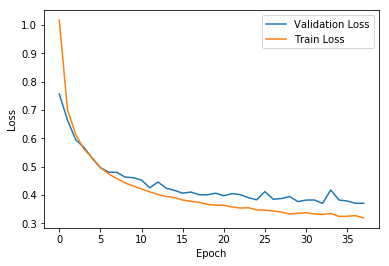

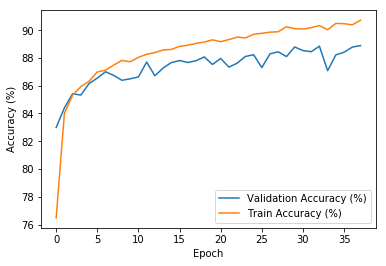

In [15]:
def plot_history(history, metric='loss', label='Loss', scaling=1):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.plot(hist['epoch'], hist['val_' + metric]*scaling,
           label='Validation ' + label)
    plt.plot(hist['epoch'], hist[metric]*scaling,
           label='Train ' + label)
    plt.legend()
    
plot_history(hist)
plot_history(hist, 'acc', 'Accuracy (%)', 100)

In [16]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

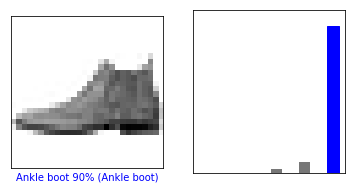

In [17]:
predictions = model.predict(test_images)

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

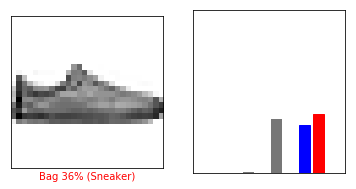

In [18]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

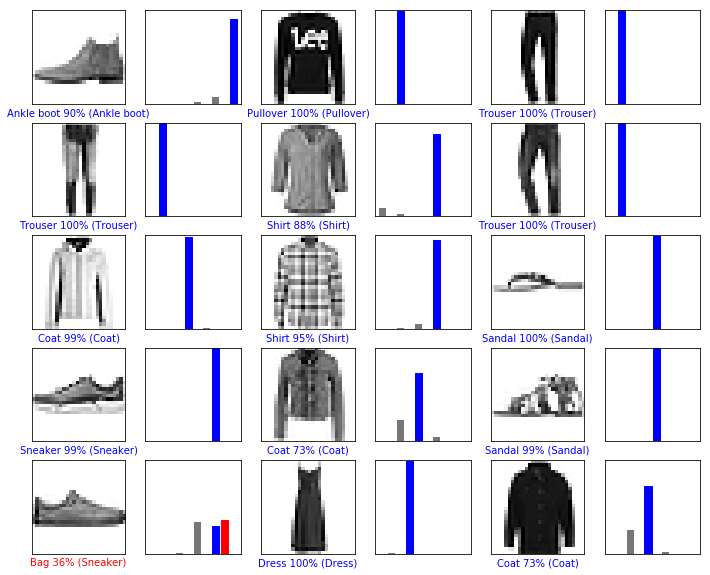

In [19]:
"""
Plot first 15 images, their predicted label, the true label
Correcct prediction = blue
Incorrect prediction = red
"""
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()